# Introduction
These functions are used to obtain the data from the server using the Obspy package.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import pickle
import copy

Let us define a retrieval function to be used for getting the data

In [11]:
def getEvents(clientName, networkName,  stationName, startTime, endTime, minMagnitude, maxRadius):
    '''
    Obtain a catalog of the seismic events around the base station
    '''
    # Find the possible earthquakes and put them in a catalog
    client = Client(clientName)
    inventory = client.get_stations(network=networkName, station=stationName)
    station = inventory[0][0]
    cat = client.get_events(starttime=startTime, endtime=endTime, minmagnitude=minMagnitude, latitude=station.latitude, longitude=station.longitude, maxradius=maxRadius)
    
    return cat

def getStreams(clientName, networkName,  stationNames, cat, timeBefore, timeAfter):
    '''
    Get the streams for the events (the seismic signal)
    '''
    # Get the stream for each event
    model = TauPyModel(model="iasp91")
    client = Client(clientName)

    
    nEvents = len(cat)
    print("Will analyze " + str(nEvents) + " events")
    stList = []
    for i in range(0, nEvents):
        for stationName in stationNames:
            try:
                inventory = client.get_stations(network=networkName, station=stationName)
                station = inventory[0][0]
                print("Analyzing event " + str(i) + " in station " + stationName)
                event = cat[i]
                origin = event.origins[0]
                distance, _, _ = gps2dist_azimuth(origin.latitude, origin.longitude, station.latitude, station.longitude)
                distance = kilometer2degrees(distance / 1e3)
                arrivals = model.get_travel_times(origin.depth / 1e3, distance)
                traveltime = arrivals[0].time
                arrival_time = origin.time + traveltime
                # Get the earthquake signal and store its needed information
                st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-timeBefore, endtime=arrival_time+timeAfter)
                stList.append(st)
            except:
                print("Could not get stream " + str(i) + " in station " +  stationName)
    return stList

def getRandomStreams(clientName, networkName,  stationNames, timeBefore, timeAfter, starttime, endtime, nEvents = 1):
    '''
    Get the streams for the events for random singals (negative labels)
    '''
    client = Client(clientName)
    
    print("Will analyze " + str(nEvents) + " events")
    stList = []
    for i in range(0, nEvents):
        for stationName in stationNames:
            try:
                inventory = client.get_stations(network=networkName, station=stationName)
                station = inventory[0][0]
                print("Analyzing random event " + str(i) + " in station " + stationName)
                arrival_time = startTime + (endTime - startTime) * np.random.random()
                st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-timeBefore, endtime=arrival_time+timeAfter)
                stList.append(st)
            except:
                print("Could not get random stream " + str(i) + " in station " +  stationName)
    return stList

let us make a function that save and load the list of seismogram. It is a list of objects so we have to use the package pickle which is included in python by default.

In [12]:
def saveList(listToSave, fileName = 'SavedList.dat'):
    '''
    Save a list into a file.
    '''
    pickle.dump( listToSave, open(fileName, "wb" ))


def loadList(fileName):
    '''
    Load a list from a file
    '''
    loadedList = pickle.load( open( fileName, "rb" ))
    return loadedList

Finally, we define a function to extract the data to numpy format for further analysis.

In [13]:
def st2numpy(st):
    '''
    Retrive information from the seismogram raw object
    '''
    trace = st.pop()
    data = trace.data
    time = trace.times('matplotlib')
    return time, data

def stList2numpy(stList , label=1):
    '''
    Retrive information from multiple seismograms and put them in an array
    '''
    nSt = len(stList)
    timeList = []
    dataList = []
    labelList = []
    
    time, data = st2numpy(stList[0])
    timeShape = time.shape
    dataShape = data.shape
    
    timeList.append(time)
    dataList.append(data)
    labelList.append(label)
    
    for i in range(1, nSt):
        time, data = st2numpy(stList[i])
        if (data.shape == dataShape):
            timeList.append(time)
            dataList.append(data)
            labelList.append(label)
    
    timeArray = np.asarray(timeList).T;
    dataArray = np.asarray(dataList).T;
    labelArray = np.asarray(labelList).T;
    labelArray = labelArray[:,np.newaxis]

    return timeArray, dataArray, labelArray
  

# Building the dataset
Now, let us retrieve the dataset and save it. This is the actual script.

In [30]:
networkName      = "BK"                                # Seismic network name
stationNames      = ["PKD", "BRK", "BDM", "WENL"]      # Station names (first station is the base station)
clientName       = "NCEDC"                             # Client name (server)
startTime        = UTCDateTime("2010-06-01")           # Start time to look for data
endTime          = UTCDateTime("2018-05-14")           # End time to look for data 
maxRadius        = .5 # angle                          # Maximum radius (in angles) away from the base station
minMagnitude     = 3                                   # Minimum seismic magnitude for teh event
channelName      = "LHZ" #vertical                     # Channel name (LHZ: 1Hz; BHZ: 40 Hz)
neg2pos = 1;                                           # Approximate negative to positive labels
secWarning = 60                                        # Number of seconds for the warning period (before seismic event)
secPrecurser = 60*60*3                                 # Number of seconds for teh seismic precurser signal 

# Obtain the siesmic events 
timeAfter  = -secWarning;     
timeBefore = secWarning+secPrecurser;
cat  = getEvents(clientName, networkName,  stationNames[0], startTime, endTime, minMagnitude, maxRadius)
print(str(len(cat))+ " seismic events found")

50 seismic events found


In [22]:
# get the data from the server
stListPositives = getStreams(clientName, networkName,  stationNames, cat, timeBefore, timeAfter)
nNegatives = int(neg2pos * len(stListPositives) / len(stationNames))
stListNegatives = getRandomStreams(clientName, networkName,  stationNames, timeBefore, timeAfter, startTime, endTime, nNegatives)

# save it in raw form (object: stream)
attributeString = "_M_" + str(minMagnitude) + "_R_" + str(maxRadius) +  "_S_" + str(len(stationNames)) + "_Sec_" + str(secPrecurser)
saveList(stListPositives, fileName = "PositivesListLowRes20Min_" + attributeString +  ".dat")
saveList(stListNegatives, fileName = "NegativesListLowRes20Min_" + attributeString +  ".dat")

Will analyze 50 events
Analyzing event 0 in station PKD
Analyzing event 0 in station BRK
Analyzing event 0 in station BDM
Could not get stream 0 in station BDM
Analyzing event 0 in station WENL
Analyzing event 1 in station PKD
Analyzing event 1 in station BRK
Analyzing event 1 in station BDM
Analyzing event 1 in station WENL
Analyzing event 2 in station PKD
Analyzing event 2 in station BRK
Analyzing event 2 in station BDM
Analyzing event 2 in station WENL
Analyzing event 3 in station PKD
Analyzing event 3 in station BRK
Analyzing event 3 in station BDM
Analyzing event 3 in station WENL
Analyzing event 4 in station PKD
Analyzing event 4 in station BRK
Analyzing event 4 in station BDM
Analyzing event 4 in station WENL
Analyzing event 5 in station PKD
Analyzing event 5 in station BRK
Analyzing event 5 in station BDM
Analyzing event 5 in station WENL
Analyzing event 6 in station PKD
Analyzing event 6 in station BRK
Analyzing event 6 in station BDM
Analyzing event 6 in station WENL
Analyzin

Analyzing random event 6 in station WENL
Analyzing random event 7 in station PKD
Analyzing random event 7 in station BRK
Analyzing random event 7 in station BDM
Analyzing random event 7 in station WENL
Analyzing random event 8 in station PKD
Analyzing random event 8 in station BRK
Analyzing random event 8 in station BDM
Analyzing random event 8 in station WENL
Analyzing random event 9 in station PKD
Analyzing random event 9 in station BRK
Analyzing random event 9 in station BDM
Analyzing random event 9 in station WENL
Analyzing random event 10 in station PKD
Analyzing random event 10 in station BRK
Analyzing random event 10 in station BDM
Analyzing random event 10 in station WENL
Analyzing random event 11 in station PKD
Analyzing random event 11 in station BRK
Analyzing random event 11 in station BDM
Analyzing random event 11 in station WENL
Analyzing random event 12 in station PKD
Analyzing random event 12 in station BRK
Analyzing random event 12 in station BDM
Analyzing random event 

In [23]:
# Convert the streams into numpy arrays
timeArrayNeg, dataArrayNeg, labelArrayNeg = stList2numpy(copy.deepcopy(stListNegatives), label = 0)
timeArrayPos, dataArrayPos, labelArrayPos = stList2numpy(copy.deepcopy(stListPositives), label = 1)

# Concatinate positive and negative arrays
time  = np.concatenate([timeArrayPos , timeArrayNeg], axis = 1);
data  = np.concatenate([dataArrayPos , dataArrayNeg], axis = 1);
label = np.concatenate([labelArrayPos , labelArrayNeg]);

# Save numpy arrays for usage in the neural network
np.save("TimeLowRes20Min" + attributeString + ".npy", time)
np.save("DataLowRes20Min" + attributeString + ".npy", data)
np.save("LabelLowRes20Min" + attributeString + ".npy", label)

## Just to make sure, Let's plot some data

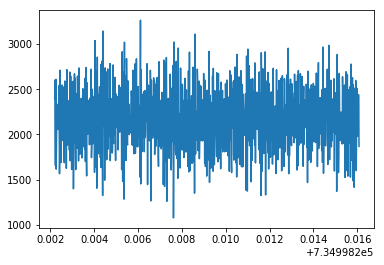

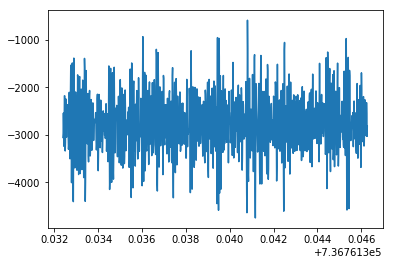

In [26]:
i = 3
fig = plt.figure()
plt.plot(timeArrayNeg[:,i], dataArrayNeg[:,i])
fig = plt.figure()
plt.plot(timeArrayPos[:,i], dataArrayPos[:,i])

## Calculate the spectogram

In [75]:
# These functions are based on Obspy internal functions

import math as M
from matplotlib import mlab
from matplotlib.colors import Normalize
from obspy.imaging.cm import obspy_sequential
import matplotlib.pyplot as plt
from skimage.transform import resize

def getSpectogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, zorder=None, title=None,
                show=True, sphinx=False, clip=[0.0, 1.0]):
    
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]

    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)
    
    return specgram, freq, time


def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


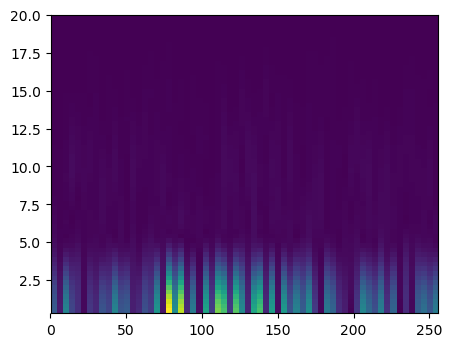

In [111]:
# Get some data and plot the spectogram
data  = np.load("Datasets\Data_M_2.8_R_0.5_S_4_Sec_256.npy")
label = np.load("Datasets\Label_M_2.8_R_0.5_S_4_Sec_256.npy")
time  = np.load("Datasets\Time_M_2.8_R_0.5_S_4_Sec_256.npy")

i = 80

specgram, freq, time = getSpectogram(data[:,i], 40)
newSize = np.round(np.array(specgram.shape) *.1)
specgram = resize(specgram,[64,64])

fig = plt.figure(num=None, figsize=(5, 4), dpi=100)
plt.imshow(specgram, extent=[np.min(time),np.max(time)    ,np.max(freq),np.min(freq)])
plt.gca().set_aspect(10)
plt.gca().invert_yaxis()

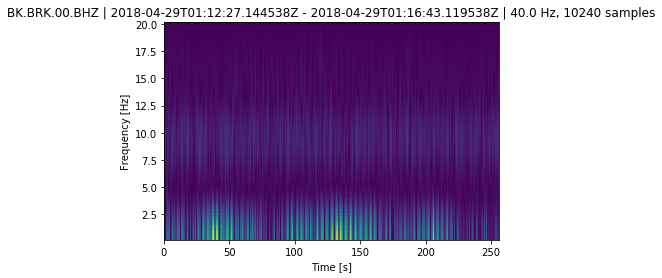

[None]

In [58]:
# Another way of plotting the spectogram (using the built in function of Obspy)
stListPositives  = np.load("Raw Data\PositivesList__M_2.8_R_0.5_S_4_Sec_256.dat")
stListPositives[1].spectrogram()